In [1]:
import pandas as pd
import polars as pl
import numpy as np
import random
import DataSets_contigs as ds
from sklearnex import patch_sklearn
patch_sklearn()
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import kaplanmeier as km
import warnings
import pymysql
import sys
import optuna
warnings.filterwarnings("ignore")
random.seed(1024)
np.random.seed(1024)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/data/teamgdansk/mwaleron/miniconda3/envs/svn-opti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
mutset = pl.read_csv("../data/Michal_combined_set_14_02_2025.tsv", separator="\t", infer_schema_length=50000)

In [ ]:
nofeaturemut = pl.read_csv("../data/Bruan_MutationExperiments_nofeatures*", dtypes={"Start_position":pl.Float64(), "End_position":pl.Float64()}).with_columns(pl.col("Start_position").cast(pl.Int64()), pl.col("End_position").cast(pl.Int64()))
arocnofeaturemut = nofeaturemut["aroc"][0]
no_feature_mutations_with_delta = nofeaturemut.with_columns(performance_delta = arocnofeaturemut-pl.col("aroc")).sort("performance_delta", descending=True).drop_nulls()
no_feature_mutations_with_delta = mutset.join(no_feature_mutations_with_delta, on=["Chromosome", "Start_position", "End_position"], suffix="suffering").sort("performance_delta", descending=True).unique(["Chromosome", "Start_position", "End_position"])

In [ ]:
contigmut = pl.read_csv("../data/Bruan_MutationExperiments_contigs.csv", dtypes={"Start_position":pl.Float64(), "End_position":pl.Float64()}).with_columns(pl.col("Start_position").cast(pl.Int64()), pl.col("End_position").cast(pl.Int64()))
aroccontigmut = contigmut["aroc"][0]
contig_mutations_with_delta = contigmut.with_columns(performance_delta = aroccontigmut-pl.col("aroc")).sort("performance_delta", descending=True).drop_nulls()
contig_mutations_with_delta = mutset.join(contig_mutations_with_delta, on=["Chromosome", "Start_position", "End_position"], suffix="suffering").sort("performance_delta", descending=True).unique(["Chromosome", "Start_position", "End_position"])

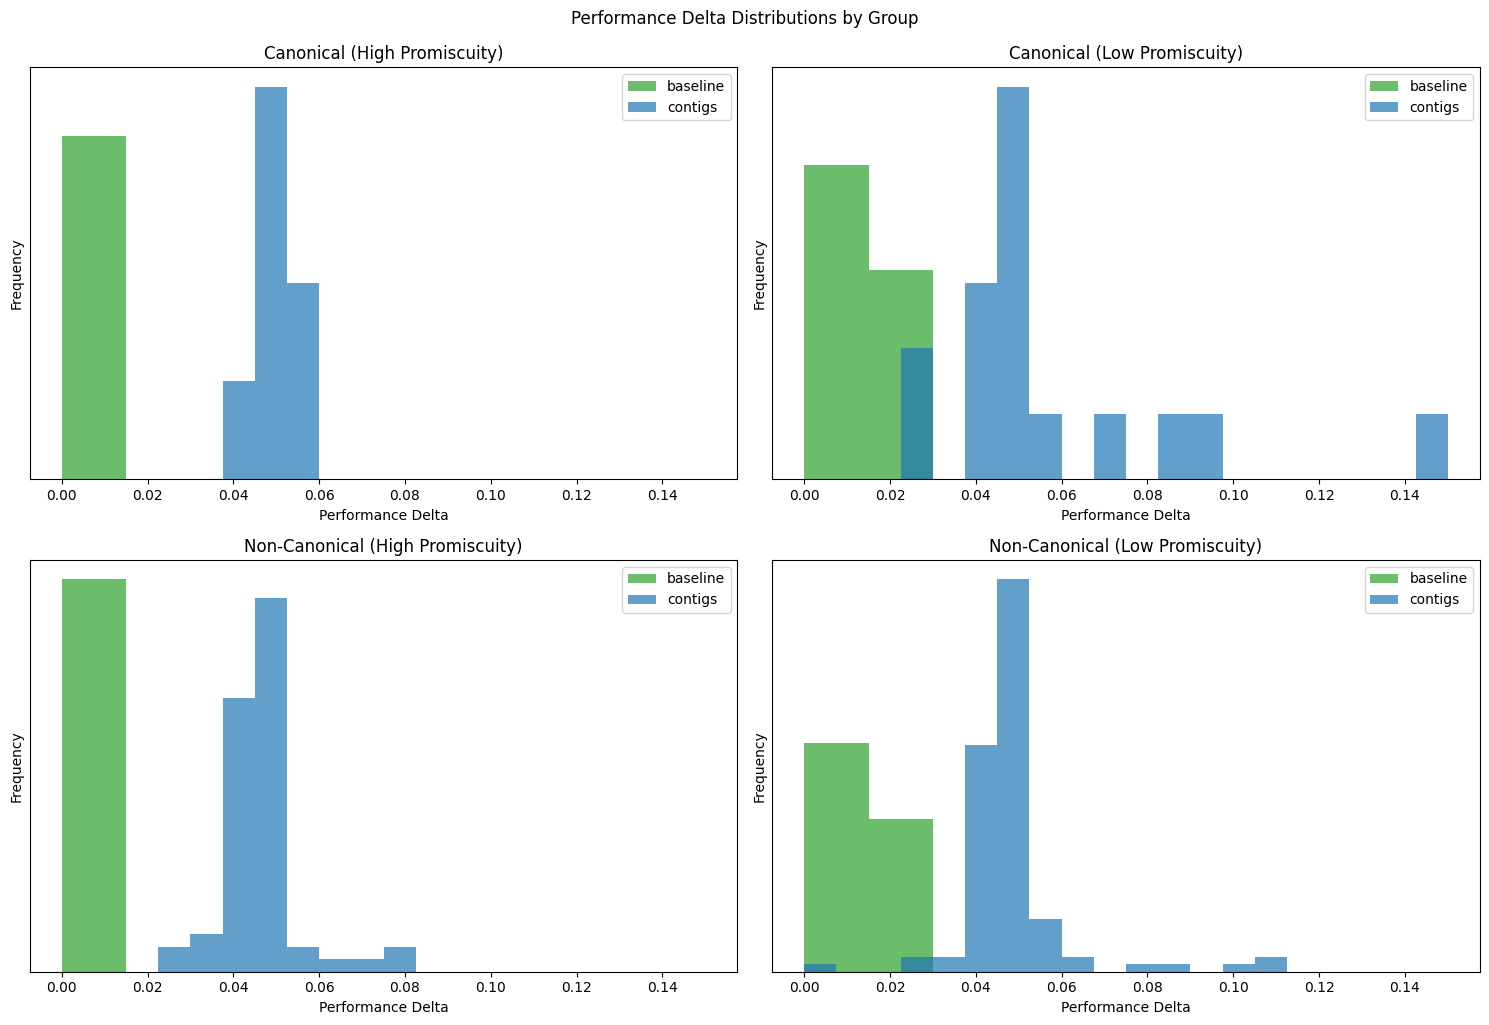

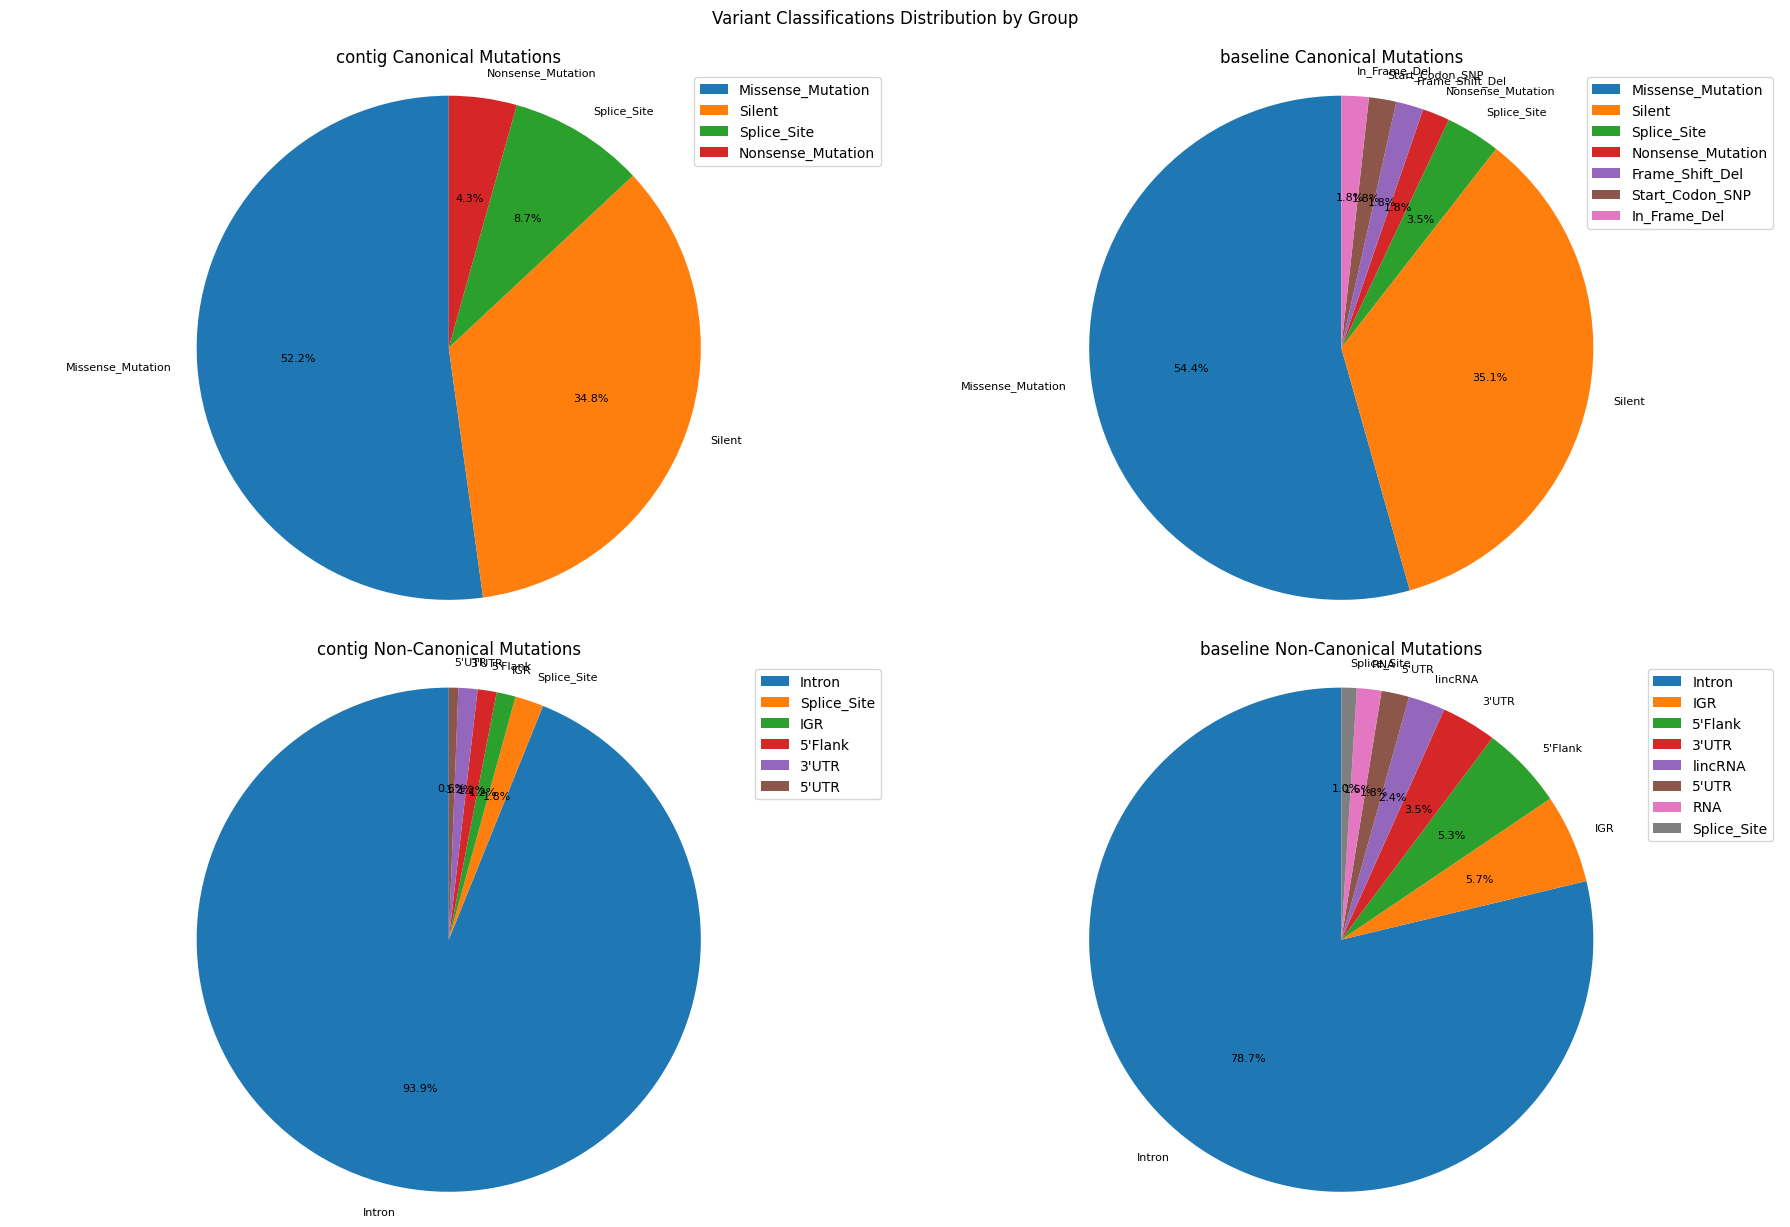

In [ ]:
canonical = contig_mutations_with_delta.filter(pl.col("Protein_Change").is_not_null())
non_canonical = contig_mutations_with_delta.filter(pl.col("Protein_Change").is_null())

canonical_high = canonical.filter(pl.col("popcov_but_sqrt") > 13)
canonical_low = canonical.filter(pl.col("popcov_but_sqrt") <= 13)
non_canonical_high = non_canonical.filter(pl.col("popcov_but_sqrt") > 13)
non_canonical_low = non_canonical.filter(pl.col("popcov_but_sqrt") <= 13)

canonical_high.write_csv("canonical_high.tsv", separator='\t')
canonical_low.write_csv("canonical_low.tsv", separator='\t')
non_canonical_high.write_csv("non_canonical_high.tsv", separator='\t')
non_canonical_low.write_csv("non_canonical_low.tsv", separator='\t')

data_subgroups = {
    "Canonical High": canonical_high["performance_delta"],
    "Canonical Low": canonical_low["performance_delta"],
    "Non-Canonical High": non_canonical_high["performance_delta"],
    "Non-Canonical Low": non_canonical_low["performance_delta"],
}

canonical_nf = no_feature_mutations_with_delta.filter(pl.col("Protein_Change").is_not_null())
non_canonical_nf = no_feature_mutations_with_delta.filter(pl.col("Protein_Change").is_null())

canonical_high_nf = canonical_nf.filter(pl.col("popcov_but_sqrt") > 13)
canonical_low_nf = canonical_nf.filter(pl.col("popcov_but_sqrt") <= 13)
non_canonical_high_nf = non_canonical_nf.filter(pl.col("popcov_but_sqrt") > 13)
non_canonical_low_nf = non_canonical_nf.filter(pl.col("popcov_but_sqrt") <= 13)

data_subgroups_nf = {
    "Canonical High": canonical_high_nf["performance_delta"],
    "Canonical Low": canonical_low_nf["performance_delta"],
    "Non-Canonical High": non_canonical_high_nf["performance_delta"],
    "Non-Canonical Low": non_canonical_low_nf["performance_delta"],
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
titles = ["Canonical (High Promiscuity)", "Canonical (Low Promiscuity)",
          "Non-Canonical (High Promiscuity)", "Non-Canonical (Low Promiscuity)"]


plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
for ax, (key, series), (key_nf, series_nf), title in zip(axes.flatten(), data_subgroups.items(), data_subgroups_nf.items(), titles):
    ax.hist(series_nf, range=(0.0,0.15), alpha=0.7, density=True, color="tab:green", label="baseline")
    ax.hist(series, bins=20, range=(0.0,0.15), alpha=0.7, density=True, label="contigs")
    ax.set_title(title)
    ax.set_xlabel('Performance Delta')
    ax.set_ylabel('Frequency')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.grid(axis='y', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.suptitle("Performance Delta Distributions by Group", y=1.02)
# plt.savefig("performance_delta_histograms.pdf")
# plt.show()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
groups = [
    (canonical, "contig Canonical Mutations"),
    (canonical_nf, "baseline Canonical Mutations"),
    (non_canonical, "contig Non-Canonical Mutations"),
    (non_canonical_nf, "baseline Non-Canonical Mutations")
]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
for ax, (group_df, title) in zip(axes.flatten(), groups):
    counts = group_df.groupby("Variant_Classification").count().sort("count", descending=True)
    labels = counts["Variant_Classification"]
    sizes = counts["count"]

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
    ax.set_title(title)
    ax.legend()
    ax.axis('equal')

plt.tight_layout()
plt.suptitle("Variant Classifications Distribution by Group", y=1.02)
# plt.savefig("variant_classifications_pie_charts.pdf")
# plt.show()
